In [1]:
import cv2 as cv
import numpy as np
import torch
from torchvision import transforms
from fft_conv_pytorch import fft_conv, FFTConv2d, FFTConv3d
import torchvision.transforms.functional as TF
import os
import math

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import matplotlib.patches as patches

import gc
from PIL import Image as im
#import napari as nap?

In [2]:
%matplotlib widget

# 1. Hough Transform for Circle Detection 
(Do not need to do everytime unless mask has changed for some ungodly reason.)

In [4]:
mask_img = cv.imread(r'./test_images/mask1.tif', cv.IMREAD_GRAYSCALE)
min_radius = int(len(mask_img[0,:])/9)

[ WARN:0@35.839] global loadsave.cpp:244 findDecoder imread_('./test_images/mask1.tif'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# Initial Hough circle detection, rounded to the nearest integer/pixel
circles = cv.HoughCircles(mask_img, cv.HOUGH_GRADIENT, 1.2, 1.5*min_radius, param1=70,param2=25, minRadius= min_radius,maxRadius=3*min_radius)
circles = np.uint16(np.around(circles))
circles = np.reshape(circles, (circles.shape[1], circles.shape[2]))

# Find which one is the center circle
circle_x_avg = np.mean(circles[:,0])
circle_y_avg = np.mean(circles[:,1])
circle_r_avg = np.mean(circles[:,2])

distances = []
theta = []

for i in range(len(circles[:,0])):
    x,y = circles[i,0]-circle_x_avg, circles[i,1]-circle_y_avg
    distances.append(np.sqrt((circles[i,0]-circle_x_avg)**2 + (circles[i,1]-circle_y_avg)**2))
    theta.append(np.arctan2(y,x))

theta = np.delete(theta, np.argmin(distances)) # Remove the center circle
distances = np.delete(distances, np.argmin(distances)) # Remove the center circle

theta = np.sort(theta) # Sort the angles
  
circle_theta_avg = np.mean(theta) # Average angle between circles
circle_theta_avg2 = (np.argmax(theta) - np.argmin(theta)) / (len(theta) - 1) #
circle_dist_avg = np.mean(distances)

figure2 = plt.figure()
figure2.set_tight_layout(True)
ax1, ax2, ax3 = figure2.subplots(1,3)
ax1.imshow(img, cmap= 'gray')

for i in circles:
    # draw the outer circle
    circle = patches.Circle((i[0],i[1]),i[2], fill = False, color = 'r')
    ax2.add_patch(circle)
    ax2.imshow(img)

for i in range(len(theta)):
    # draw the center circle
    center = patches.Circle((circle_x_avg,circle_y_avg),circle_r_avg, fill = False, color = 'r')
    # Draw the outer circles by multiplying the average angle by i
    circle = patches.Circle((circle_x_avg+circle_dist_avg*np.cos(theta[i]),circle_y_avg+circle_dist_avg*np.sin(theta[i])),circle_r_avg, fill = False, color = 'r') # really good fit
    ax3.add_patch(center)
    ax3.add_patch(circle)
    ax3.imshow(img)

In [ ]:
circles_corrected = np.array([circle_x_avg, circle_y_avg, circle_r_avg])

for i in range(len(theta)):
    circles_corrected = np.vstack((circles_corrected, (circle_x_avg+circle_dist_avg*np.cos(theta[i]), circle_y_avg+circle_dist_avg*np.sin(theta[i]), circle_r_avg))) # new circle centers and radii

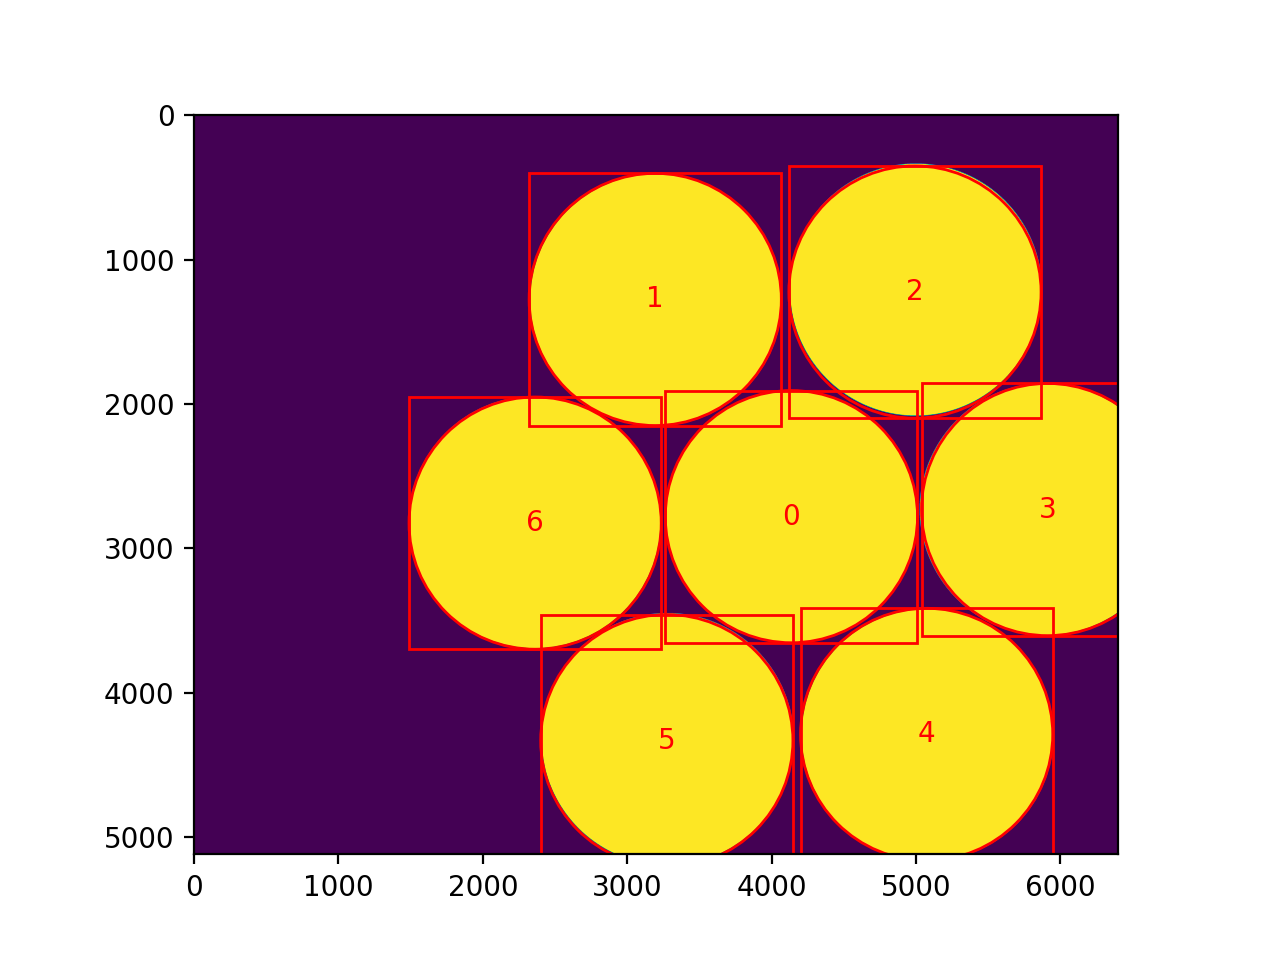

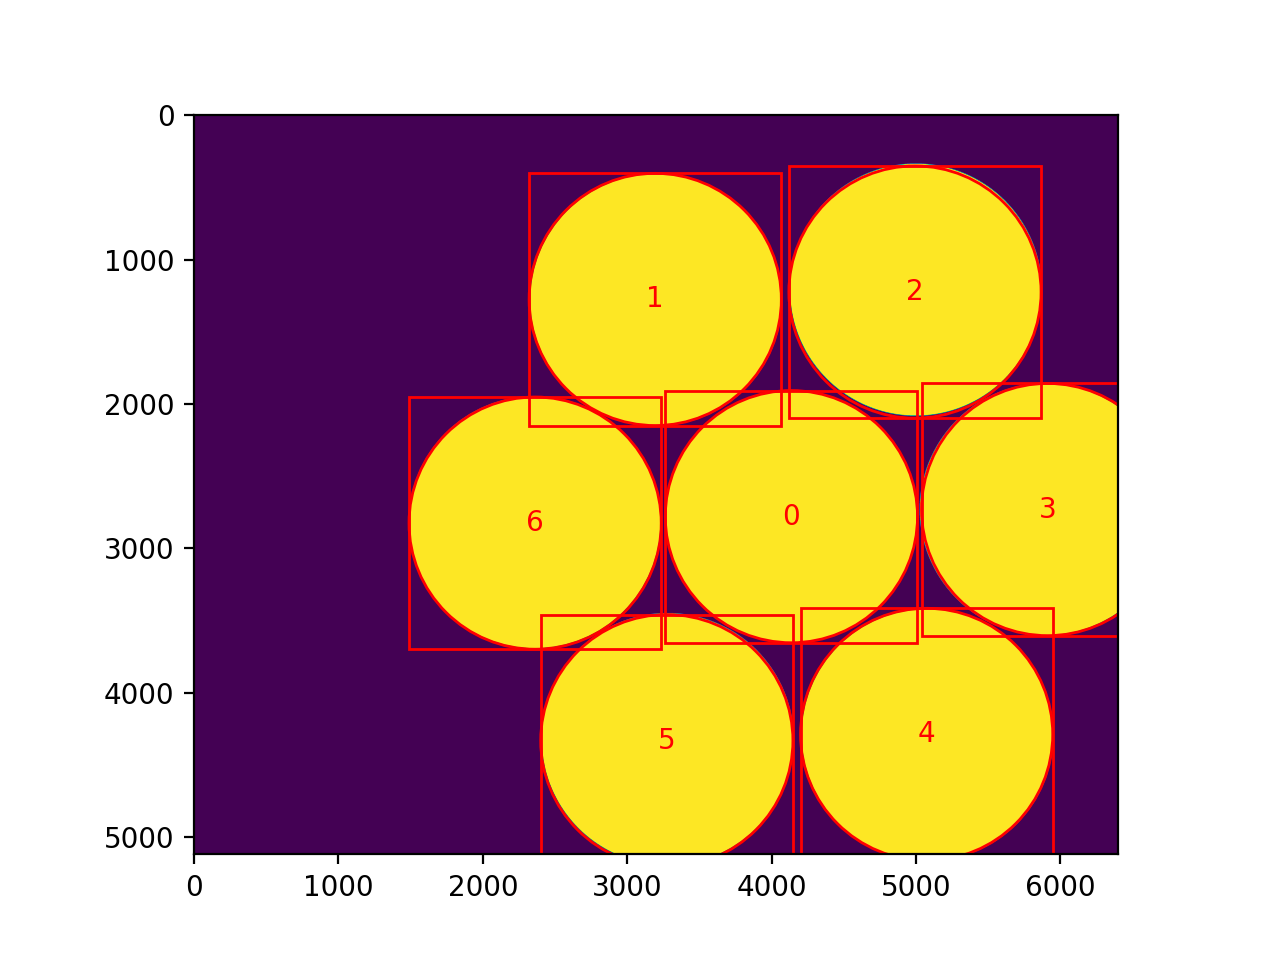

In [ ]:
# Display corrected circles
mask_fit = plt.figure()
ax1 = mask_fit.subplots(1,1)

ax1.imshow(mask_img)

for i in range(len(circles_corrected[:,0])):
    # draw the outer circle
    squares = patches.Rectangle((circles_corrected[i,0]-circles_corrected[i,2], circles_corrected[i,1]-circles_corrected[i,2]), 2*circles_corrected[i,2], 2*circles_corrected[i,2], fill = False, color = 'r')
    circle = patches.Circle((circles_corrected[i,0],circles_corrected[i,1]),circles_corrected[i,2], fill = False, color = 'r')
    ax1.add_patch(squares)
    ax1.add_patch(circle)
    
    # Add the order of the circles in the center of each circle
    ax1.text(circles_corrected[i,0], circles_corrected[i,1], str(i), color = 'r', horizontalalignment='center', verticalalignment='center')

mask_fit.show()

### Choose the "center" lenslet

In [ ]:
center_lenslet = int(0) # center circle index

# Import frames for testing

### In the near future, auto-pulling frames from videos will be added.

In [ ]:
image_path = [r'./test_images/img_time1_1.tif', r'./test_images/img_time1_2.tif']

In [ ]:
image_path = [r'./test_images/img_time1_1.tif', r'./test_images/img_time1_2.tif']
frames = [] # List of frames
for i in image_path:
    imge = im.open(i)
    frames.append(np.array(imge).astype(np.int16))

# Check if the frames are all the same size
if np.unique([frames[i].shape for i in range(len(frames))]).size > 2:
    raise ValueError('Frames are not all the same size!')

# Check if the frames are the same size as the mask
if np.any(np.unique([frames[i].shape for i in range(len(frames))]) != mask_img.shape) == True:
    raise ValueError('Frames are not the same size as the mask!')

figure4 = plt.figure()
ax1 = figure4.subplots(1,1)

for i in range(len(circles_corrected[:,0])):
    # draw the outer circle
    squares = patches.Rectangle((circles_corrected[i,0]-circles_corrected[i,2], circles_corrected[i,1]-circles_corrected[i,2]), 2*circles_corrected[i,2], 2*circles_corrected[i,2], fill = False, color = 'r')
    circle = patches.Circle((circles_corrected[i,0],circles_corrected[i,1]),circles_corrected[i,2], fill = False, color = 'r')
    ax1.add_patch(squares)
    ax1.add_patch(circle)
    # Add the order of the circles in the center of each circle
    ax1.text(circles_corrected[i,0], circles_corrected[i,1], str(i), color = 'r', horizontalalignment='center', verticalalignment='center')
    #plot the centers of the circles
    ax1.scatter(int(circles_corrected[i,0]), int(circles_corrected[i,1]), color = 'b')
    
ax1.imshow(frames[0], cmap= 'gray')

In [ ]:
lenslet_distances_og = np.zeros((len(circles_corrected[:,0]), len(circles_corrected[:,0])))
lenslet_angles = np.zeros((len(circles_corrected[:,0]), len(circles_corrected[:,0])))

# Find the distances between the lenset centers
for i in range(len(circles_corrected[:,0])):
    for j in range(len(circles_corrected[:,0])):
        lenslet_distances_og[i,j] = (np.sqrt((circles_corrected[i,0]-circles_corrected[j,0])**2 + (circles_corrected[i,1]-circles_corrected[j,1])**2))
        lenslet_angles[i,j] = np.arctan2(circles_corrected[i,1]-circles_corrected[j,1], circles_corrected[i,0]-circles_corrected[j,0])

# Grab the 2nd diagonal of the matrix
lenslet_distances = np.diagonal(lenslet_distances_og, offset = 1)
lenslet_angles = np.diagonal(lenslet_angles, offset = 1)
lenslet_distance_avg = np.mean(lenslet_distances)

In [ ]:
lenslet_circle_mask = np.zeros((int(2*circles_corrected[0,2]+1),int(2*circles_corrected[0,2]+1)))

# Create a circular mask that has 0s outside the circle and 1s inside the circle
for i in range(int(2*circles_corrected[0,2]+1)):
    r = circles_corrected[0,2]
    for j in range(int(2*circles_corrected[0,2]+1)):
        
        if np.sqrt((i-r)**2 + (j-r)**2) <= r: # Assuming the radius of the first circle is the same as the rest
            lenslet_circle_mask[i,j] = 1
        else:
            lenslet_circle_mask[i,j] = 0

mask_tensor = torch.from_numpy(lenslet_circle_mask)

In [ ]:
perspectives = torch.zeros(int(len(frames)), int(len(circles_corrected[:,0])) , int(2*circles_corrected[0,2]+1), int(2*circles_corrected[0,2]+1)) # Making the different perspectives te "channels", also the frames are always odd numbers
# The first dimension is the frame number, the second dimension is the lenslet number, the third and fourth dimensions are the x and y dimensions of the lenslet

for i in range(len(frames)):
    for j in range(len(circles_corrected[:,0])):
        placeholder = torch.Tensor(frames[i][int(circles_corrected[j,1]-circles_corrected[j,2]):int(circles_corrected[j,1]+circles_corrected[j,2]), int(circles_corrected[j,0]-circles_corrected[j,2]):int(circles_corrected[j,0]+circles_corrected[j,2])]) # Don't know why x and y are switched
        
        if placeholder.shape == perspectives[0,0,:,:].shape:
            placeholder[:,:] = torch.mul(placeholder, mask_tensor)
            perspectives[i,j,:,:] = placeholder[:,:]
            
        else:
            # If the circle is too close to the edge of the image, we need to pad it
            placeholder_x_deficit = int(2*circles_corrected[j,2]+1) - placeholder.shape[0]
            placeholder_y_deficit = int(2*circles_corrected[j,2]+1) - placeholder.shape[1]
            
            if placeholder_x_deficit > 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder_x_deficit, placeholder.shape[1])), 0)
            if placeholder_y_deficit > 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder.shape[0], placeholder_y_deficit)), 1)
            if placeholder_x_deficit < 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder_x_deficit, placeholder.shape[1])), 0)
            if placeholder_y_deficit < 0:
                placeholder = torch.cat((placeholder, torch.zeros(placeholder.shape[0], placeholder_y_deficit)), 1)
                
            placeholder[:,:] = torch.mul(placeholder, mask_tensor)
            perspectives[i,j,:,:] = placeholder[:,:] # This is the same as the placeholder, but padded with zeros if the circle is too close to the edge of the image

In [ ]:
torch.save(perspectives, './models_DONOTCOMMIT/perspectives.pt')

# Plotting the different perspectives
figure4 = plt.figure()
ax1,ax2 = figure4.subplots(1,2)

ith= int(1)
jth= int(0)

ax1.imshow(perspectives[ith,jth,:,:], cmap= 'gray')
ax2.imshow(frames[ith][int(circles_corrected[jth,1]-circles_corrected[jth,2]):int(circles_corrected[jth,1]+circles_corrected[jth,2]), int(circles_corrected[jth,0]-circles_corrected[jth,2]):int(circles_corrected[jth,0]+circles_corrected[jth,2])], cmap= 'gray')

# Frames are all loaded, time to calculate the forward and backward projectors

### Camera-related info

Future: Allow .txt files to be imported and read instead.

Current values grabbed from FLFMconfigGW.yml

In [ ]:
# Set-up Specific Constants
grid_Type = "hex"

NA = 0.4
fobj = 10000
f1 = 1
f2 = 1
fm = np.array([47000])

mla2sensor = 47000 # microns
lenspitch = 2520 # Lens pitch in microns 
pixel_size = 3.54 # Also referred to as pixel pitch in microns/px
refractive_index = 1 # Refractive index of the medium
wavelength = 0.5530

noLensHoriz = 3
noLensVert = 3

spacingPixels = 777
horizOffset = 1269
vertOffset = 690

shiftRow = 0
gridRot = 0

In [ ]:
def FLFM_setCameraParams(config):
    # Config should be an array with the following parameters:
    # [NA, fobj, f1, f2, fm, mla2sensor, lenspitch, pixel_size, wavelength, refractive_index, noLensHoriz, noLensVert, spacingPixels, horizOffset, vertOffset, shiftRow, gridRot]
    
    objRad = config[0] * config[1] # Objective radius = NA * fobj
    k = 2 * np.pi * config[9] / config[8] # k = 2 * pi * refractive_index / wavelength (wave number)
    M = (config[4] * config[3]) / (config[2] * config[1]) # Magnification = fm * f2 / (f1 * fobj)
    d_refract = 3.5e-3 # Index of Refraction (__Don't know wherer the number came from__)
    fsRad = config[6] * config[3] / (2 * config[4]) # Field stop radius = lenspitch * f2 / (2 * fm)
    fovRad = fsRad / config[2]
    return [objRad, k, M, d_refract, fsRad, fovRad]

# Example: camera_params = FLFM_setCameraParams(config)

In [ ]:
def resolution(camera_params, depth_step):
    # Find the number of pixels behind a lesnlet
    lenslet_pixels = [len(perspectives[0,0,0,:]), len(perspectives[0,0,:,0])]
    # Corresponding sensor resolution
    sensor_res = pixel_size
    object_res = [pixel_size/camera_params[2], pixel_size/camera_params[2], depth_step] # config[2] is the magnification
    fovRadVox = (camera_params[5] / i for i in object_res)  # Field of view radius in voxels
    return [lenslet_pixels, sensor_res, object_res, fovRadVox]

# example: res = resolution(camera_params, 10)

### Load-in camera-related info

In [ ]:
camera_params = FLFM_setCameraParams([NA, fobj, f1, f2, fm, mla2sensor, lenspitch, pixel_size, wavelength, refractive_index, noLensHoriz, noLensVert, spacingPixels, horizOffset, vertOffset, shiftRow, gridRot])

In [ ]:
res = resolution(camera_params, 10)

### Transmittance & PSF

Code originally written in MatLab by Stefanoiu et. al, ported and modified by me.

> Resolution.yspace, and Resolution.xspace is the sensor spatial space, in microns.

> This should be calculated as the pixel size * (# of pixels in x, # of pixels in y), assuming that each pixel is square.


Implementation in pyFLFM (This code):
> sensor_res * [-sensorsize/2, sensorsize/2], with # of steps between the two numbers being the # of pixels in each direction (i.e. sensor_size)

### Transmittance

In [ ]:
def transmittance(wavenumber, lenslet_centers, calibration_img, focal_lengths, pixel_pitch):
    # Defining the local lenslet space
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    lenslet_pixels = 2*round(lenslet_centers[0,2])
    
    lenslet_pitch = pixel_pitch * lenslet_pixels # Supposedly the lenslet pitch is 2x the radius of the lenslet
    
    NNum_half = (lenslet_pixels / 2) # Number of pixels in the numerator, assuming the lenslet is square
    xML = pixel_pitch * torch.arange(start=-NNum_half+1, end=NNum_half-1, step = 1, dtype = torch.float32) # x coordinates of the lenslet space
    yML = xML.clone() # y coordinates of the lenslet space in the same units as xML
    
    #ulens_transmittance = np.zeros((len(focal_lengths),len(xML),len(yML)), dtype = np.complex64) # [focal length, x, y]
    ulens_transmittance = torch.zeros([len(focal_lengths),len(xML),len(yML)], dtype = torch.complex64) # [focal length, x, y]
    # Indexing: [lenslet x, lenslet y, focal length]
    # Lenslet centers is saved as [lens no, [x,y,r]]
    # We already have the distances between the lenslets, so we need to find the correct index for the x norm and y norm

    distance = (torch.pow(xML.tile((len(xML),1)),2) + torch.pow(yML.reshape(-1,1).tile((1,len(yML))),2))
    #distance = distance.numpy()


    condition = (distance < (lenslet_pitch/2)**2) # Condition for the lenslet transmittance, is 1 inside the lenslet and 0 outside the lenslet
    #condition.dtype
    condition = condition.to(torch.complex64)
    distance = distance.to(torch.complex64)
    #print(distance_squared)
    
    exp_workaround = (-0.5 * distance * wavenumber / focal_lengths[0]).to(torch.complex64)
    mul_test = torch.mul(torch.tensor(1j)*torch.sin(exp_workaround) + torch.cos(exp_workaround), condition)
    #print(torch.angle(torch.tensor(1j)*torch.sin(exp_workaround) + torch.cos(exp_workaround)))

    #exp_workaround = np.multiply(-0.5j * wavenumber / focal_lengths[0] , distance).astype(np.complex64)
    
    for c in range(len(focal_lengths)):
        ulens_transmittance[c,:,:] = torch.mul(torch.cos(exp_workaround) + torch.tensor(1j, dtype = torch.complex64) * torch.sin(exp_workaround), condition) # Exp seems to not work properly, so I'm using cos and sin instead #+ torch.mul(torch.tensor(1j), test)
        ulens_transmittance = torch.mul((ulens_transmittance[c,:,:]), condition).unsqueeze(0)
        
    #ulens_transmittance = torch.from_numpy(ulens_transmittance)

    # lenslet_centers_tensor is a tensor that has 1s where the lenslet centers are and 0s everywhere else
    lenslet_centers_tensor = torch.zeros((len(calibration_img[0,:]), len(calibration_img[:,0])), dtype=torch.complex64).unsqueeze(0).unsqueeze(0).to(device) # [0,0,x,y]
    
    #lenslet_centers_tensor[0,0,lenslet_centers[:,0],lenslet_centers[:,1]] = 1

    ulens_transmittance = ulens_transmittance.unsqueeze(0).to(device)# [0,focal length,x,y]
    
    for i in range(len(lenslet_centers[:,0])):
        # Grab a kernel sized chunk of the lenslet centers tensor, but don't go out of bounds. Instead, pad with zeros
        #lenslet_center_x = lenslet_distances_norm[i,0] + np.ceil((lenslet_centers_tensor.shape[2] +1) /2) # The center of the lenslet in the lenslet space
        #lenslet_center_y = lenslet_distances_norm[i,1] + np.ceil((lenslet_centers_tensor.shape[3] +1) /2) # The center of the lenslet in the lenslet space
        
        lenslet_center_x = lenslet_centers[i,0] #+ np.ceil((lenslet_centers_tensor.shape[2] +1) /2) # The center of the lenslet in the lenslet space
        lenslet_center_y = lenslet_centers[i,1] #+ np.ceil((lenslet_centers_tensor.shape[3] +1) /2) # The center of the lenslet in the lenslet space
            
        grab_x_start = int(lenslet_center_x - np.ceil((ulens_transmittance.shape[2] +1) /2))
        grab_y_start = int(lenslet_center_y - np.ceil((ulens_transmittance.shape[3] +1) /2))
        grab_x_end = int(lenslet_center_x + np.floor((ulens_transmittance.shape[2] -1) /2))
        grab_y_end = int(lenslet_center_y + np.floor((ulens_transmittance.shape[3] -1) /2))
        
        pull_x_start = int(0)
        pull_y_start = int(0)
        pull_x_end = int(ulens_transmittance.shape[2])
        pull_y_end = int(ulens_transmittance.shape[3])
        
        if grab_x_start < 0:
            pull_x_start = int(abs(grab_x_start)+1)
            grab_x_start = int(0)
        if grab_y_start < 0:
            pull_y_start = int(abs(grab_y_start)+1)
            grab_y_start = int(0)
        if grab_x_end > int(lenslet_centers_tensor.shape[2]):
            grab_x_end = int(lenslet_centers_tensor.shape[2])
            pull_x_end = int(grab_x_end - grab_x_start)
        if grab_y_end > int(lenslet_centers_tensor.shape[3]):
            grab_y_end = int(lenslet_centers_tensor.shape[3])
            pull_y_end = int(grab_y_end - grab_y_start)
        
        lenslet_centers_tensor[:,:,grab_x_start:grab_x_end,grab_y_start:grab_y_end] = ulens_transmittance[:,:,pull_x_start:pull_x_end,pull_y_start:pull_y_end]

    return lenslet_centers_tensor, ulens_transmittance

In [ ]:
ulens_transmit, single_lens_transmittance = transmittance(camera_params[1], circles_corrected, mask_img, fm, pixel_size)

figure5 = plt.figure()
figure5.set_tight_layout(True)
ax1, ax2 = figure5.subplots(1,2)
ax1.imshow(torch.real(single_lens_transmittance[0,0,:,:]))
ax2.imshow(torch.imag(ulens_transmit[0,0,:,:]))

# note that the plot looks like it's been flipped upside down, but it's just because of the way the image is plotted

### PSF

>resolution.yspace, resolution.xspace is the sensor spatial space! (defined as sensor_res * [-sensorsize/2, sensorsize/2] with steps = # of pixels in the direction (=sensor_size)

>Nnum is number of pixels behind each lenslet

>resolution.yMLspace, resolution.xMLspace is the MLA spatial space (defined as sensor_res * [-Nnum/2, Nnum/2], steps of 1

>Sensor_size is calibration picture resolution in pixels

>sensor_res is um/px

In [ ]:
# Properties that I do not know and I will just use the values in the code
proportion = 3
LU0 = 2500  # microns, physical length of the of sampled input at the NOP
N_calcPSF = 7999  # Resolution of the point spread function

In [ ]:
def psfCalc(fobj, k, NA, calibration_img, pixel_pitch, wavelength, n, depths):
    # Feed in depths as a list of depths
    
    device = "cpu"
    
    #if torch.cuda.is_available():
    #    device = torch.device("cuda:0")
    #else:
    #    device = torch.device("cpu")
    
    sensor_spatial = [int(len(calibration_img[:,0]) * pixel_pitch /2 ), int(len(calibration_img[0,:]) * pixel_pitch /2 )]# sensor size (in micron) = pixel size (in micron/px) * sensor size (in px)
    sensor_size = [int(len(calibration_img[:,0])), int(len(calibration_img[0,:]))] # sensor size in pixels
    
    # fobj = objective focal length
    # k = wave number
    # NA = objective numerical aperture
    # sensor_size = size of the sensor in microns, calculated from the calibration image size and the pixel size, sensor size (in micron) = pixel size (in micron/px) * sensor size (in px)
    # d = lenslet pitch
    # n = refractive index
    # n_step = number of steps in the z direction
    
    # phase delay suffered by the rays is the optical path difference (WHy are we calculating this?)
    #if n != n_step:
        #theta_half = theta / 2
       # diff = (d / config[8]) * (n-n_step) * (1 + 2*n / n_step * np.sin(theta_half)^2 + 2*(n+n_step) * (n**2) / (n_step**3) * np.sin(theta_half)^4)
    #else:
       #diff = 0
        
    # Now we simulate the propagation of the rays to the sensor plane
    
    amp = 1000 # Normalized amplitude of the rays
    mid = int((N_calcPSF+1)/2) # Where the delta function is located, N_calcPSF is always odd
    NOP_x = torch.linspace(-LU0/2, LU0/2, N_calcPSF, dtype = torch.float32).to(device) # x coordinates of the NOP plane
    NOP_y = NOP_x.clone() # y coordinates of the NOP plane, we assume the NOP is square
    x, y = torch.meshgrid(NOP_x, NOP_y, indexing = 'ij') # Meshgrid of the NOP
    
    scale_factor = max(sensor_size)/ N_calcPSF # Scale factor to account for the difference in the size of the sensor and the size of the PSF

    psf_sensor = torch.zeros(len(depths), sensor_size[0], sensor_size[1]).to(device).to(torch.complex64) # Initialize the PSF with the sensor size
    
    dobj = 2 * NA * fobj # Diameter of the objective
    M_relay = f2 / f1 # Relay magnification
    
    def circ(x, y, r):
        return (x**2 + y**2 < r**2).to(int)
    
    # We note that the PSF is shift-invariant, so we can calculate the PSF at the origin
    for i in range(len(depths)):
        if depths[i] == 0:
            depths[i] = 1e-8 # To avoid division by 0
        
        r = torch.div(torch.sqrt(torch.pow(x,2) + torch.pow(y,2) + torch.pow(depths[i], 2)),n) # Distance from the origin to the sensor plane
        
        if depths[i] > 0:
            r = -r # To propogate to the lens
        
        U0 = torch.mul(torch.div(amp * k * torch.tensor([-1j], dtype = torch.complex64, device=device),r),torch.exp(torch.mul(k*torch.tensor([1j], dtype = torch.complex64,device = device), r))) / (2 * torch.pi)

        source_sample_rate = LU0 / len(U0) # Sampling rate of the input field
        U1 = torch.mul(torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(U0))), source_sample_rate**2).to(dtype=torch.complex64) # Propogate to the sensor plane, with a scaling factor to account for the sampling
        coeffU1 = torch.tensor([-1j], dtype = torch.complex64,device=device) * torch.exp(k * fobj * torch.tensor([1j], dtype = torch.complex64, device = device)) / wavelength / fobj
        U1 = torch.mul(coeffU1, U1)
        
        LU1 = wavelength * fobj / source_sample_rate # Physical length of the sampled input field at the sensor plane
        
        U1 = torch.mul(U1, circ(x*LU1/LU0, y*LU1/LU0, dobj/2)) # Multiply the PSF by the circle mask
        
        cut = [round(sensor_spatial[0] * (N_calcPSF + 1) / (2 * (M_relay * LU1))), round(sensor_spatial[1] * (N_calcPSF + 1) / (2 * M_relay * LU1))]
        
        U1 = U1[mid-cut[0]:mid+cut[0], mid-cut[1]:mid+cut[1]].unsqueeze(0).unsqueeze(0) # Cut the PSF to the correct size
        
        U1_real_resize = transforms.Resize(size = sensor_size , interpolation=transforms.InterpolationMode.BICUBIC, antialias=False)(torch.real(U1)) # Resize the PSF to the sensor size
        U1_imag_resize = transforms.Resize(size = sensor_size , interpolation=transforms.InterpolationMode.BICUBIC, antialias=False)(torch.imag(U1)) # Resize the PSF to the sensor size
        U1 = torch.complex(U1_real_resize, U1_imag_resize)
        del U1_real_resize, U1_imag_resize
        
        U1 = U1.squeeze(0).squeeze(0)
        
        # When PSF is smaller than the sensor, we need to index the sensor space to the correct location
        if len(U1[:,0]) < sensor_size[0]:
            push_x_start = 0
            push_x_end = len(U1[:,0])
            pull_x_start = int((sensor_size[0] - len(U1[:,0]))/2)
            pull_x_end = int((sensor_size[0] + len(U1[:,0]))/2)
        
        if len(U1[0,:]) < sensor_size[1]:
            push_y_start = 0
            push_y_end = len(U1[0,:])
            pull_y_start = int((sensor_size[1] - len(U1[0,:]))/2)
            pull_y_end = int((sensor_size[1] + len(U1[0,:]))/2)
        
        # When the PSF is bigger than the sensor, we need to crop the psf
        if len(U1[:,0]) >= sensor_size[0]:
            push_x_start = int((len(U1[:,0])-sensor_size[0])/2)
            push_x_end = int((len(U1[:,0])+sensor_size[0])/2)
            pull_x_start = int(0)
            pull_x_end = int(sensor_size[0])
        
        if len(U1[0,:]) >= sensor_size[1]:
            push_y_start = int((len(U1[0,:])-sensor_size[1])/2)
            push_y_end = int((len(U1[0,:])+sensor_size[1])/2)
            pull_y_start = int(0)
            pull_y_end = int(sensor_size[1])

        psf_sensor[i, pull_x_start:pull_x_end, pull_y_start:pull_y_end] = U1[push_x_start:push_x_end, push_y_start:push_y_end]
        #psf_sensor[i,:,:] = transforms.Resize(size = sensor_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=False)(psf)[0,0,:,:] # Resize the PSF to the sensor size
        
        del U0, r, cut
            
    # Shift the center of the PSF to the center of the center lenslet
    #psf_sensor = torch.roll(psf_sensor, shifts= (-int(lenslet_centers[center_lenslet, 0] - (sensor_size[0]/2)), -int(lenslet_centers[center_lenslet, 1] - (sensor_size[1]/2))), dims = (2,1))
        
    return psf_sensor

In [ ]:
depths = torch.linspace(-100, 100, 20) # Depths in microns, 10 microns is the increment between depths
psfStack = psfCalc(fobj, camera_params[1], NA, mask_img, pixel_size, wavelength, refractive_index, depths) # CPU usage is at 100% when running this. GPU would be better.
torch.save(psfStack, './models_DONOTCOMMIT/psfStack.pt')

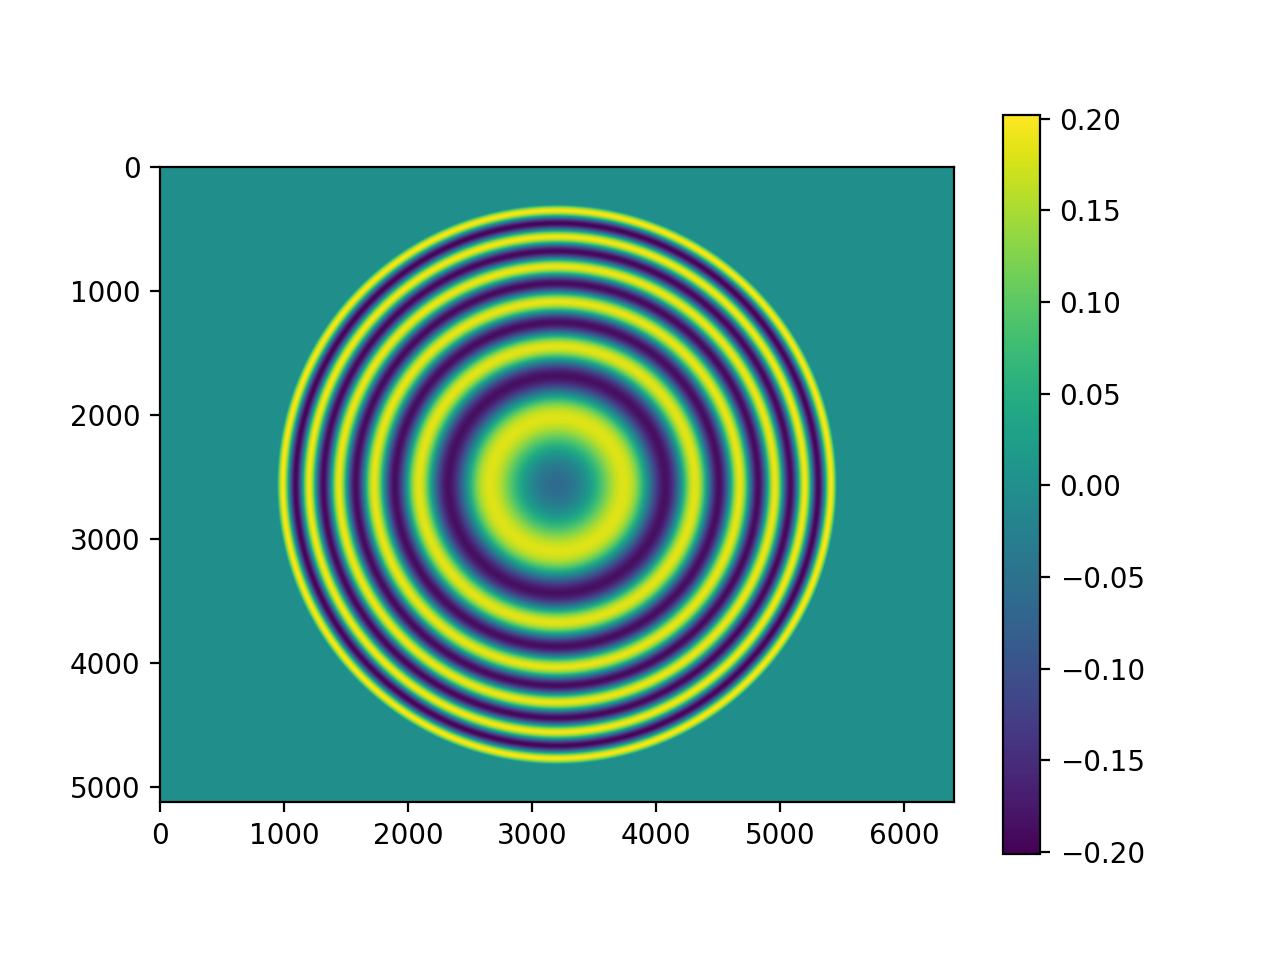

In [ ]:
# Plotting the PSF
figure5 = plt.figure()
#figure5.set_tight_layout(True)
# make a 3d plot of the PSF with the depths as the z-axis
ax = figure5.add_subplot(111)
ax.set_aspect(len(psfStack[0,0,:])/len(psfStack[0,:,0]))
figure5.colorbar(ax.imshow(np.real(psfStack[0,:,:])))
ax.imshow(np.imag(psfStack[6,:,:]))

In [ ]:
def LFPSF(psfStack, calibration_image, pixel_size, mla2sensor, wavelength, ulens_transmittance, depths, device, path, save_psf = False):
    
    # psfStack is in the format [depth, x, y]
    
    if device == "cuda":
        print(torch.cuda.is_available())
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    elif device == "cpu":
        device = torch.device("cpu")
    elif device == "mps":
        print("MPS may have unforeseen consequences...")
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    else:
        print("Device not recognized, using CPU")
        device = torch.device("cpu")
    
    ulens_transmittance = ulens_transmittance.to(device)

    forward = np.empty( (len(calibration_image[:,0]), len(calibration_image[0,:]), len(psfStack[:,0,0]))).astype(np.complex64)
    backward = np.empty( (len(calibration_image[0,:]), len(calibration_image[:,0]), len(depths))).astype(np.float32)
    
    Nx = len(psfStack[0,:,0])
    Ny = len(psfStack[0,0,:])
    k = 2 * torch.pi / wavelength
    
    du = torch.div(1, (Nx * pixel_size))
    dv = torch.div(1, (Ny * pixel_size))
    u = torch.concatenate((torch.arange(0, np.ceil(Nx/2)), torch.arange(np.ceil(-Nx/2), 0))).to(device) * du
    v = torch.concatenate((torch.arange(0, np.ceil(Ny/2)), torch.arange(np.ceil(-Ny/2), 0))).to(device) * dv
    
    u = u.cpu().numpy().astype(complex) # Exp workaround; pytorch gives false values for the exp function
    v = v.cpu().numpy().astype(complex) # Exp workaround; pytorch gives false values for the exp function
    
    H = np.exp(1j * mla2sensor * k * np.emath.sqrt(1 - (wavelength**2) * (np.power(np.tile(u.reshape(-1, 1),(1, len(v))), 2) + np.power(np.tile(v,(len(u),1)), 2)))) # Transfer function of the lenslet array, u and v are the spatial frequencies, v first, then u
    #exp_workaround_1 = mla2sensor * k * torch.sqrt(1 - (wavelength**2) * (torch.pow(u.reshape(-1, 1).repeat(1, len(v)), 2) + torch.pow(v.repeat(len(u),1), 2)))
    #H = torch.cos(exp_workaround_1) + torch.mul(torch.tensor(1j), torch.sin(exp_workaround_1)) # Transfer function of the lenslet array, u and v are the spatial frequencies, v first, then u
    #H = torch.exp(torch.tensor(1j, dtype=torch.complex64, device=device) * mla2sensor * k * torch.sqrt((1 - (wavelength**2) * mla2sensor * k * (torch.pow(u.reshape(-1, 1).repeat(1, len(v)), 2) + torch.pow(v.repeat(len(u),1), 2))).to(torch.complex64))) # Transfer function of the lenslet array, u and v are the spatial frequencies, v first, then u
    
    for i in range(len(psfStack[:,0,0])):
        psfMLA = torch.mul(psfStack[i,:,:].to(device), torch.permute(ulens_transmittance[0,0,:,:].to(device).squeeze(0), (1,0)).squeeze(0)).cpu().numpy().astype(complex) # Multiply the PSF by the transmittance function
        #exp_workaround2 = torch.cos(torch.tensor(k * mla2sensor)) + torch.mul(torch.tensor(1j), torch.sin(torch.tensor(k * mla2sensor)))
        forward[:,:,i] = np.abs(np.emath.power(np.exp(1j * mla2sensor * k) * np.fft.ifft2(np.multiply(np.fft.fft2(psfMLA),H)), 2))
        #forward[:,:,i] = torch.abs(torch.pow(torch.exp(1j*  mla2sensor * k * torch.sqrt(1 - (wavelength**2) * (torch.pow(u.reshape(-1, 1).repeat(1, len(v)), 2) + torch.pow(v.repeat(len(u),1), 2)))) * (torch.fft.ifft2(torch.mul(torch.fft.fft2(psfMLA),H))) ,2))
        #forward[:,:,i] = torch.abs(torch.pow(exp_workaround2 * (torch.fft.ifft2(torch.mul(torch.fft.fft2(psfMLA),H))) ,2))
    
    forward = torch.from_numpy(forward.astype(np.float32))
    backward = forward.clone()
    
    # Side note
    # 1. The backward model is the same as the forward model, so transpose results afterwards.
    # 2. Scaling and normalizing should be done cleverly, as the floating point numbers become very small and creatte numerical instability (i.e. negative numbers, NaNs, etc.)
    
    return forward, backward, psfMLA

In [ ]:
save_path = r"./models_DONOTCOMMIT/"

In [ ]:
forward_test, backward_test, h = LFPSF(psfStack[:,:,:], mask_img, pixel_size, mla2sensor, wavelength, ulens_transmit, depths, "cuda", save_path, True) # This would be a great place to use multiprocessing/multithreading.

True


C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_18896\1439186875.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  forward = torch.from_numpy(forward.astype(np.float32))


In [ ]:
torch.save(forward_test, save_path + "forward_test.pt")
torch.save(backward_test, save_path + "backward_test.pt")

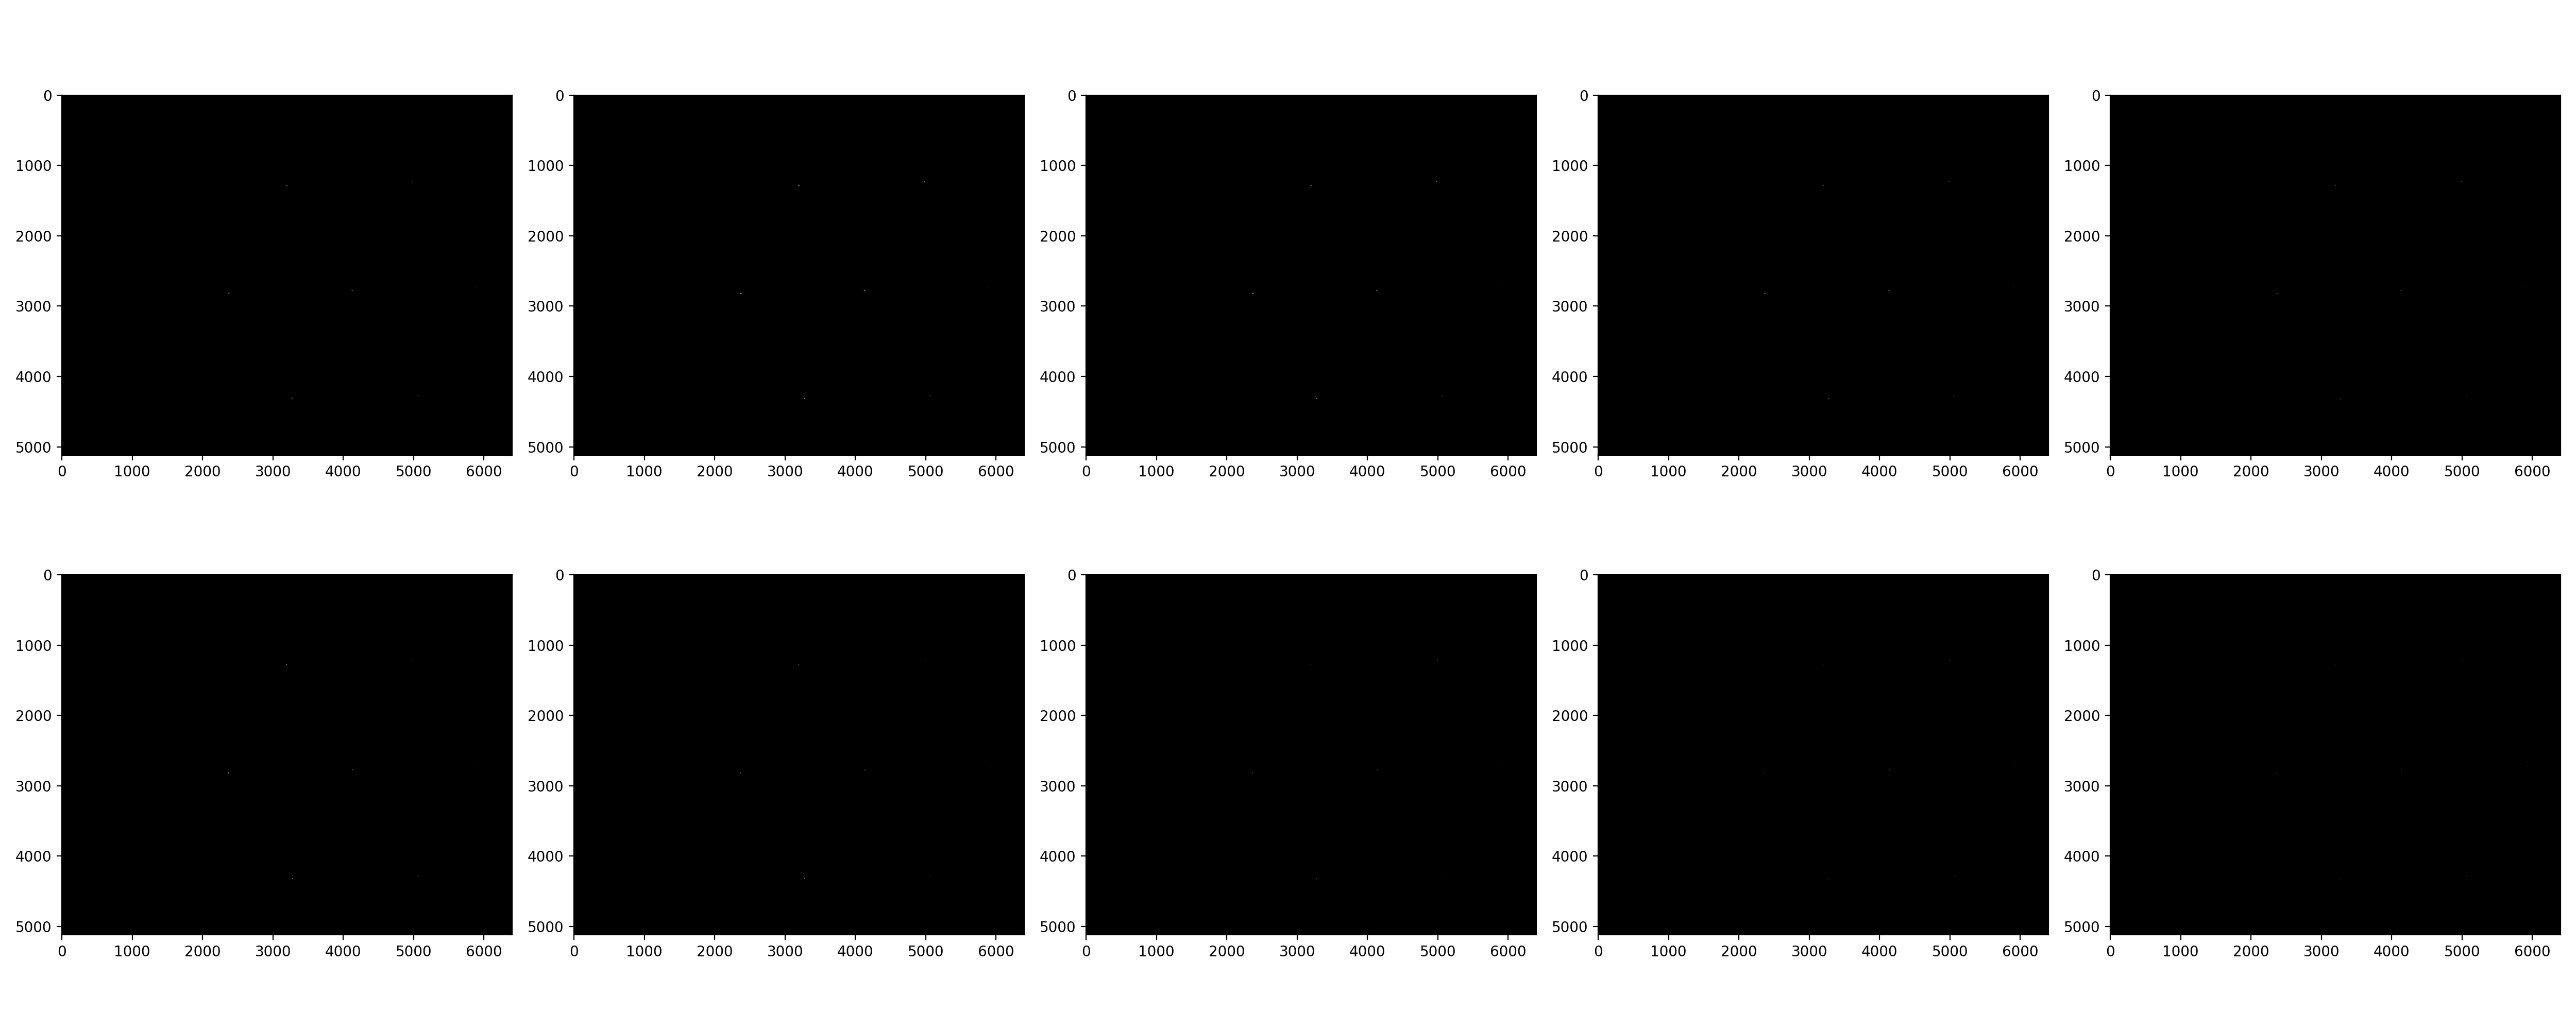

In [ ]:
forward_figures = plt.figure(figsize = (25,10))
forward_figures.set_tight_layout(True)

forward_maximum = torch.amax(forward_test[:,:,10:], (0,1,2)).item()

forward_ax = forward_figures.subplots(2,5).flatten()

for i in range(len(forward_ax)):
    forward_ax[i].imshow(forward_test[:,:,i], cmap = 'gray')

In [ ]:
def combine_lenslets(lenslet_info, depths, path):
    # Lenslet_info has the format [x, y, r]
    # Depth has the format [z]
    # Assuming that the file naming convention is frame_lenslet_depth.pt
    # If folder is given, all the files in the folder will be grabbed that match the naming convention
    # If path is given, the file will be grabbed from the path
    
    if os.path.isfile(path):
        return_tensor = torch.zeros((len(lenslet_info), 2 * int(max(lenslet_info[:, 2])) + 1, 2 * int(max(lenslet_info[:, 2])) + 1 ), dtype=torch.float32).to('cpu')
        image_tensor = torch.load(path).to('cpu')
        for i in range(len(lenslet_info[:,0])):
            # Have to check if padding is necessary
            image_x_deficit = int(2*lenslet_info[i,2]+1) + int(lenslet_info[i,0]) - image_tensor.shape[0] # The amount of padding needed on the x axis
            image_y_deficit = int(2*lenslet_info[i,2]+1) + int(lenslet_info[i,1]) - image_tensor.shape[1] # The amount of padding needed on the y axis
            
            if image_x_deficit > 0: # This means that the part of the image we want to grab has a deficit on the right side
                x_end = len(image_tensor[:,0])
            if image_x_deficit < 0: # This means that the part of the image we want to grab has a deficit on the left side
                x_start = 0
            
            if image_y_deficit > 0: # This means that the part of the image we want to grab has a deficit on the bottom side
                y_end = len(image_tensor[0,:])
            if image_y_deficit < 0: # This means that the part of the image we want to grab has a deficit on the top side
                y_start = 0
            
            return_tensor[:,:] += image_tensor[x_start:x_end, y_start:y_end]
        
        del image_tensor
        gc.collect()

    
    if os.path.isdir(path):
        return_tensor = torch.zeros((len(lenslet_info), len(depths), 2 * int(max(lenslet_info[:, 2])) + 1, 2 * int(max(lenslet_info[:, 2])) + 1 ), dtype=torch.float32).to('cpu')
        files = os.listdir(path)
        for file in files:
            if file.endswith(".pt"):
                file_info = file.split(".")[0].split("_")
                if len(file_info) == 2:
                    frame_number = int(file_info[0])
                    depth_number = int(file_info[1])
                    image_tensor = torch.load(path+file).to('cpu')
                    for i in range(len(lenslet_info[:,0])):
                        # Have to check if padding is necessary
                        image_x_deficit = int(2*lenslet_info[i,2]+1) + int(lenslet_info[i,0]) - image_tensor.shape[0] # The amount of padding needed on the x axis
                        image_y_deficit = int(2*lenslet_info[i,2]+1) + int(lenslet_info[i,1]) - image_tensor.shape[1] # The amount of padding needed on the y axis
                        
                        if image_x_deficit > 0: # This means that the part of the image we want to grab has a deficit on the right side
                            x_end = int(len(image_tensor[:,0]))
                        if image_x_deficit < 0: # This means that the part of the image we want to grab has a deficit on the left side
                            x_start = 0
                        
                        if image_y_deficit > 0: # This means that the part of the image we want to grab has a deficit on the bottom side
                            y_end = int(len(image_tensor[0,:]))
                        if image_y_deficit < 0: # This means that the part of the image we want to grab has a deficit on the top side
                            y_start = 0
                        
                        return_tensor[i, depth_number,:,:] += image_tensor[x_start:x_end, y_start:y_end]
                        
                    del image_tensor
                    gc.collect()

    return return_tensor

In [ ]:
def load_psf(path, normalize):
    # Loads the PSF stack from a path
    #path = r'/Users/halensolomon/Code/FLFM_local/testing/psf_stack.pt'
    
    # if the file type is .pt, then we can just load it
    if path[-3:] == '.pt':
        psf = torch.load(path)
        
        if normalize == True:
            for i in range(len(psf[:,0,0])):
                psf[i,:,:] = torch.div(psf[i,:,:],torch.sum(psf[i,:,:])) # Sum of each axial slice should be 1
    
    # if the path is actually a folder, then we need to load in all the files in the folder
    elif os.path.isdir(path):
        psf = torch.zeros(len(os.listdir(path)), len(Image.open(path + '/' + os.listdir(path)[0]).convert('L').getdata()), len(Image.open(path + '/' + os.listdir(path)[0]).convert('L').getdata()))
        
        for i in range(len(os.listdir(path))): # Format is [depth, x, y]
            psf[i,:,:] = torch.from_numpy(np.array(Image.open(path + '/' + os.listdir(path)[i]).convert('L').getdata()).reshape(Image.open(path + '/' + os.listdir(path)[i]).convert('L').size))
            if normalize == True:
                psf[i,:,:] = torch.div(psf[i,:,:],torch.sum(psf[i,:,:])) # Sum of each axial slice should be 1
    
    return psf

# Deconvolution and Filtering

In [ ]:
def fft_convolve_images(image, kernel_stack, summation = False):
    # image is the image to be convolved
    # kernel_stack is the stack of kernels to be convolved with the image
    
    # The image and the kernel stack should be the same size
    # The kernel stack should be in the format [depth, x, y]
    return_tensor = torch.fft.ifftshift(torch.fft.ifft2(torch.mul(torch.fft.fft2(image), torch.fft.fft2(torch.div(kernel_stack, torch.sum(kernel_stack, dim = (1,2)).unsqueeze(1).unsqueeze(2)))), dim = (1,2))) # Convolve the image with the kernel stack
        
    if summation == True:
        return_tensor = torch.sum(return_tensor, 0) # Sum all of the convolutions
    
    return return_tensor

In [ ]:
def richardson_lucy(e_i, oringinal_image, f, b):
    torch.set_device('')
    pad = (f[0][0].shape[0] - 1)/2
    pad = int(pad)
    
    kernel_size = f.shape[0]
    func1 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size, stride=1, padding = pad, device = 'mps')
    func1.weight = f
    denom = func1(e_i)
    
    kernel_size = b.shape[0]
    func2 = torch.nn.Conv2d(1, 1, kernel_size=kernel_size, stride=1, padding = pad, device = 'mps')
    func2.weight = b
    factor = func2(oringinal_image/denom)
    
    return e_i * factor

def psf_WB_filter(psf, alpha, beta, pixelSize, depth_step, butterworth_order):
    # Assuming that there is only one peak in the lenslet
    # Frames is the input frames, given as a 

    if len(psf.shape) == 3:
        psf = psf.unsqueeze(0) # Add a dimension for the lenslets, since only one lenslet was given

    # input PSF size and center
    _, Sz, Sx, Sy = psf.shape
    Scx = (Sx+1)/2;
    Scy = (Sy+1)/2
    Scz = (Sz+1)/2
    Sox = round((Sx+1)/2)
    Soy = round((Sy+1)/2)
    Soz = round((Sz+1)/2)
    
    # Pixel size in Fourier domain
    px = 1/Sx
    py = 1/Sy
    pz = 1/Sz
    
    # Remember that the psf is in the format of [lenslet, depth, x, y]
    # Permute the PSF to the format of [lenslet, x, y, depth]
    psf = torch.permute(psf, (0, 2, 3, 1)) # [lenslet, x, y, depth]
    
    PSF_bp = torch.empty(psf.shape)
    
    psf_flip = torch.flip(psf, (1,2,3))
    OTF_flip = torch.fft.fftn(psf_flip, dim = (1,2,3))
    OTF_abs = torch.fft.fftshift(torch.abs(OTF_flip), dim = (1,2,3))
    M = torch.amax(OTF_abs, (1,2), keepdim = True) # find maximum value and position
    OTF_abs_norm = torch.div(OTF_abs, M)
    
    # Create Wiener filter
    OTF_flip_norm = OTF_flip/M
    OTF_Wiener = torch.div(OTF_flip_norm,(torch.pow(torch.abs(OTF_flip_norm),2) + alpha))
    
    # Calculate Cut-off Gain for Wiener Filter
    OTF_Wiener_abs = torch.fft.fftshift(torch.abs(OTF_Wiener))
    
    # tplane = abs(squeeze(OTF_Wiener_a   bs(:,:,Soz))); % central slice
    tplane = torch.abs(OTF_Wiener_abs[:,:,Soz]) # central slice
    tline, _ = torch.max(tplane, dim=0, keepdim=False) # Should return maximums along each row, call each depth
    
    w = np.power((np.tile(np.arange(0,Sx), (Sy,1)).T - Scx),2)+ np.power((np.tile(np.arange(0,Sy),(Sx,1)) - Scy),2)
    w = np.broadcast_to(w[...,None],w.shape+(Sz,)) + np.power(np.tile(np.arange(0,Sz).reshape(1,1,Sz),(Sx,Sy,1)) - Scz, 2) # repeat Sz in the 3rd dimension
    w = torch.from_numpy(w)
            
    if len(psf.shape) == 3:
        psf = psf.unsqueeze(0) # Add a dimension for the lenslets, since only one lenslet was given
    
    PSF_bp = torch.empty(psf.shape)
    mask = torch.empty(Sx,Sy,Sz)

    # Loop through all the lenslets
    for j in range(int(psf.shape[0])):
        # Loop through all the depths
        for i in range(int(psf.shape[3])):
            psf_numpy = psf[j,:,:,i].numpy()
            # Grab the x and y coordinates of the maximum value of the PSF
            [x,y] = np.where(psf_numpy == np.max(psf_numpy))
            
            # Grab the x and y slices of the PSF that contain the maximum value
            psf_x = psf_numpy[:,y]
            psf_y = psf_numpy[x,:]
            
            # Find the indices that are near the half-maximum of the PSF
            idx_x = (np.abs(psf_x - (psf_numpy[x,y]/2))).argmin()
            idx_y = (np.abs(psf_y - (psf_numpy[x,y]/2))).argmin()
            
            # Set the resolution cutoff by setting the resolution to the FWHM
            resx = np.abs(x - idx_x) * pixelSize
            resy = np.abs(y - idx_y) * pixelSize
            resz = depth_step # The MatLab code assumes that the resolution is the same in all directions
            
            # Frequency cutoff in terms of pixels
            tx = 1/resx/px
            ty = 1/resy/py
            tz = 1/resz/pz
            
            # to1 = max(round(Scx -tx), 1); to2 = min(round(Scx+tx), Sx);
            to1 = max(np.round(Scx - tx), 1)
            to2 = min(np.round(Scx + tx), Sx)
            
            # beta_wienerx = (tline(to1) + tline(to2))/2; % OTF frequency intensity at cutoff:x
            beta_wienerx = (tline[:,i][to1] + tline[:,i][to2])/2 # OTF frequency intensity at cutoff:x

            ee = beta_wienerx/(beta**2) - 1
            
            mask[:,:,i] = torch.div(1, torch.sqrt(1 + torch.mul(ee,(torch.pow(w[:,:,i],butterworth_order))))) # w^n = (kx/kcx)^pn
            mask[:,:,i] = torch.fft.ifftshift(mask[:,:,i]) # Butterworth Filter

        # Create Wiener-Butteworth Filter
        OTF_bp = torch.mul(mask,OTF_Wiener) # Final OTF_bp cutfoff gain: beta
            
        PSF_bp[j,:,:,:] = torch.fft.fftshift(torch.real(torch.fft.ifftn(OTF_bp)))# final OTF_bp cutfoff gain: beta
        
    return PSF_bp

In [ ]:
def two_n_squareify(tensor):
    # This function takes a tensor and pads it with zeros until the dimensions are a power of 2
    # The return tensor is a square tensor
    
    # Find the next power of 2
    next_power = max(2**math.ceil(math.log2(len(tensor[0,:,0]))), 2**math.ceil(math.log2(len(tensor[0,0,:]))))
    
    # Find the amount of padding needed
    x_pad = next_power - len(tensor[0,:,0])
    y_pad = next_power - len(tensor[0,0,:])
    
    # Check to see if it's even or odd
    if x_pad % 2 == 0:
        l_x_pad = int(x_pad/2)
        r_x_pad = int(x_pad/2)
    else:
        l_x_pad = int(x_pad/2)
        r_x_pad = x_pad - int(x_pad/2)
    
    if y_pad % 2 == 0:
        l_y_pad = int(y_pad/2)
        r_y_pad = int(y_pad/2)
    else:
        l_y_pad = int(y_pad/2)
        r_y_pad = y_pad - int(y_pad/2)
    
    return_tensor = torch.nn.functional.pad(tensor, (l_y_pad, r_y_pad, l_x_pad, r_x_pad), "constant", 0)
    
    return return_tensor

In [ ]:
def rl_deconv(frames, PSF, PSF_bp, device, iterations = 10, path = r"./", cpu_option = 'cpu', temp_storage = False):
    # Take the whole lenslet image & the whole PSFs and apply the Richardson-Lucy algorithm to it
    # Frames should be in the format of [time, x, y]
    # PSF should be in the format of [depths, x, y]
    # Output should be in the format of [time, depth, x, y]
    # cpu_option is the device that does the division and the multiplication.
    # temp_storage dictates how the temporary storage is handled. If it is set to True, then the temporary storage is saved to the disk. If it is set to False, then the temporary storage is saved to the RAM.
    
    # So, FFTConv2D CAN work, it's just that we have to process one channel at a time and empty out cache after each iteration.
    # The problem is that the memory is not being freed up after each iteration. This is a problem with the way that the memory is being handled.
    
    conv2d = torch.nn.Conv2d(1, 1, kernel_size = (len(PSF_bp[0,:,0]), len(PSF_bp[0,0,:])), stride = 1, padding = 'same', bias = False).to(device)
    
    with torch.no_grad():
        if type(frames) != torch.Tensor:
            frames = torch.tensor(frames)
            gc.collect()
        
        if frames.dtype != torch.float16:
            frames = frames.to(torch.float16)
            gc.collect()
            
        if device == 'cuda':
            torch.cuda.empty_cache()
        
        for k in range(len(frames[:,0,0])):
            # Each time step
            print("Creating projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
            
            original_image = frames[k,:,:].clone().detach().to(cpu_option) # Format: (x,y)
            projected_volume = torch.empty([len(PSF[:,0,0]), len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float16).detach().to(cpu_option) # Format: (depth, x,y)
            projected_image = original_image.clone().detach() # Format: (x,y), we do not want the original image to be modified
            
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            for i in range(len(PSF[:,0,0])): # Save the projected volume to the CPU memory, but use gpu to do the calculations (if possible)
                conv2d.weights = torch.nn.parameter.Parameter(torch.div(PSF_bp[i,:,:].detach(), torch.sum(PSF_bp[i,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0))
                temp_vol = conv2d(original_image.detach().unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0)
                
                if temp_storage == True:
                    torch.save(temp_vol, path +'tempvol'+ '_' + str(i) + '.pt')
                    
                if temp_storage == False:
                    projected_volume[i,:,:] = temp_vol.to(cpu_option)
                    
                del temp_vol
                gc.collect()

                if device == 'cuda':
                    torch.cuda.empty_cache()
            
            for j in range(iterations):
                print("Now processing iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                # Schema:
                # Calculate the projected image (Sum of o_i * PSF)
                # Divide the original image by the projected image (original_image / projected_image), (should be done on the cpu?)                
                # Convolve the ratio with the backward projector (ratio * PSF_bp)
                # Multiply the original image by the result of the convolution (original_image * result)
                # Repeat until the iterations are done
                
                # Denominator results in a projected image
                
                for i in range(len(PSF[:,0,0])):
                    conv2d.weight = torch.nn.parameter.Parameter(torch.div(PSF[i,:,:].detach(), PSF[i,:,:].detach()).detach().to(device).unsqueeze(0).unsqueeze(0))
                    
                    if temp_storage == True:
                        temp_vol = torch.load(path + 'tempvol' + '_' + str(i) + '.pt').to(device)
                        projected_image += conv2d(temp_vol.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option)
                        del temp_vol
                        gc.collect()
                    
                    projected_image += conv2d(projected_volume[i,:,:].unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0).to(cpu_option)
                    if temp_storage == False:
                        projected_image += conv2d(projected_volume[i,:,:].unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0).to(cpu_option)
                    
                    if device == 'cuda':
                        torch.cuda.empty_cache()
                
                # We have the projected image, now take the ratio. The projected image is in 'device'.
                
                image_ratio = torch.nan_to_num(torch.div(original_image,projected_image).to(cpu_option), 1) # If the projected image is 0, then the ratio is 1
                
                # Convolve the ratio with the backward projector
                
                factor = torch.empty([len(PSF[:,0,0]),len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float16).to(cpu_option) # Format: (depth,x,y)\
                
                for i in range(len(PSF_bp[:,0,0])):
                    conv2d.weight = torch.nn.parameter.Parameter(torch.div(PSF_bp[i,:,:].detach(), torch.sum(PSF_bp[i,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0).to(device))
                    factor = conv2d(image_ratio.to(device).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option)
                    
                    if temp_storage == True:
                        torch.save(factor, path + 'factor' + '_' + str(i) + '.pt')
                        
                    elif temp_storage == False:
                        factor[i,:,:] = conv2d(image_ratio.to(device).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option)
                    
                del image_ratio # We don't need this anymore
                gc.collect()
                
                if device == 'cuda':
                    torch.cuda.empty_cache()
                
                # We have the new factor, now multiply it by the original volume
                if temp_storage == True:
                    for i in range(len(PSF[:,0,0])):
                        temp_vol = torch.load(path + 'tempvol' + '_' + str(i) + '.pt').to(cpu_option)
                        temp_factor = torch.load(path + 'factor' + '_' + str(i) + '.pt').to(cpu_option)
                        torch.save(torch.mul(temp_vol, temp_factor), path +'tempvol'+ '_' + str(i) + '.pt')
                        
                        del temp_vol, temp_factor
                        gc.collect()
                        
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                
                if temp_storage == False:    
                    projected_volume[:,:,:] = torch.mul(projected_volume[:,:,:].to(cpu_option), factor[:,:,:].to(cpu_option)).to(cpu_option)
            
            print("Finished processing frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now saving the results")
            if temp_storage == False:
                torch.save(projected_volume, path + str(k) + '.pt')
                  
            for i in range(len(PSF[:,0,0])):
                if temp_storage == True:
                    os.rename(path + 'tempvol' + '_' + str(i) + '.pt', path + str(k) + '_' + str(i) + '.pt')
        
        del projected_volume, projected_image, original_image, factor
        gc.collect()
        
        if device == 'cuda':
            torch.cuda.empty_cache()
            
    return None

In [ ]:
def img_to_psf(path):
    # Find all images in a folder:
    imgs = []
    accepted_filetypes = ['tif', 'tiff', 'png', 'jpg', 'jpeg', 'bmp']
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1][1:]
        if ext.lower() not in accepted_filetypes:
            continue
        imgs.append(cv.imread(path+f, cv.IMREAD_GRAYSCALE).astype(np.float32))

    # Convert them into a tensor for pyTorch
    tensor_imgs = torch.from_numpy(np.array(imgs,dtype=np.float32)).to(torch.float32)
    del imgs
    gc.collect()
    
    return tensor_imgs

In [ ]:
image_path = [r'./test_images/img_time1_1.tif', r'./test_images/img_time1_2.tif']
frames = [] # List of frames
for i in image_path:
    imge = im.open(i)
    frames.append(np.array(imge).astype(np.float32))

In [ ]:
threshold = torch.nn.Threshold(1e-3, 0, True)

forward_test = torch.load(r"./models_DONOTCOMMIT/forward_test.pt")
forward_test = threshold(torch.permute(forward_test.to(torch.float16), (2,0,1)))

backward_test = torch.load(r"./models_DONOTCOMMIT/backward_test.pt")
backward_test = threshold(torch.permute(backward_test.to(torch.float16), (2,0,1)))

C:\Users\XStream_Server\AppData\Local\Temp\ipykernel_11888\1091570926.py:4: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:301.)
  forward_test = threshold(torch.permute(forward_test.to(torch.float16), (2,0,1)))


In [ ]:
forward_test.shape
backward_test.shape

torch.Size([20, 5120, 6400])

In [ ]:
forward_test = two_n_squareify(forward_test)
backward_test = torch.transpose(two_n_squareify(backward_test), 1, 2)
frames = two_n_squareify(torch.tensor(np.array(frames)))

In [ ]:
print(forward_test.shape,backward_test.shape)

torch.Size([20, 8192, 8192]) torch.Size([20, 8192, 8192])


In [ ]:
conv_trial = fft_convolve_images(frames[0].to(torch.float32).to('cpu'), backward_test.to(torch.float32).to('cpu'), summation = False) 
# Really good performance on CPU, but takes a long time on GPU (16x slower)

In [ ]:
frames_rl = rl_deconv(frames, forward_test, backward_test, "cuda", 1, r"./test_images/", "cuda", False)

Creating projected volume and image for frame 1 out of 2
Now processing iteration 1 out of 1 for frame 1 out of 2
Finished processing frame 1 out of 2, now saving the results
Creating projected volume and image for frame 2 out of 2
Now processing iteration 1 out of 1 for frame 2 out of 2
Finished processing frame 2 out of 2, now saving the results


Approximately 14 seconds for each iteration. (Assuming CUDA-enabled, using RTX A5500)

In [ ]:
import scipy.signal as signal

In [ ]:
vol_to_img = FFTConv2d(1, 1, kernel_size=backward_test[0,:,:].shape, stride=1, padding = 'same', bias = False, groups = 1)
vol_to_img.weights = torch.nn.parameter.Parameter(torch.div(backward_test[0,:,:], torch.sum(backward_test[0,:,:])).unsqueeze(0).unsqueeze(0))
test_vti = vol_to_img(frames[0,:,:].unsqueeze(0).unsqueeze(0))

In [ ]:
img_fft = torch.fft.fft2(frames[0,:,:].to(torch.float32))
kernel_fft = torch.fft.fft2(torch.div(torch.transpose(backward_test[0,:,:],0,1).to(torch.float32),torch.sum(backward_test[0,:,:].to(torch.float32))))

In [ ]:
test2 = torch.fft.ifftshift(torch.fft.ifft2(torch.mul(img_fft, kernel_fft)))

In [ ]:
test_2 = torch.fft.ifftshift(torch.fft.ifft2(torch.mul(torch.fft.fft2(frames[0]), torch.fft.fft2(torch.div(backward_test[0,:,:], torch.sum(backward_test[0,:,:], dim = (1,2)).unsqueeze(1).unsqueeze(2)))))) # Convolve the image with the kernel stack

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
plt.close('all')

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
#ax2.imshow(torch.load(r"./test_images/0.pt")[0,:,:].numpy(), cmap = 'gray')
ax2.imshow(test2.to(torch.float16).detach().squeeze(0).squeeze(0).numpy(), cmap = 'gray')
#ax2.imshow(conv_trial[0,:,:].cpu().to(torch.float16).numpy(), cmap = 'gray')

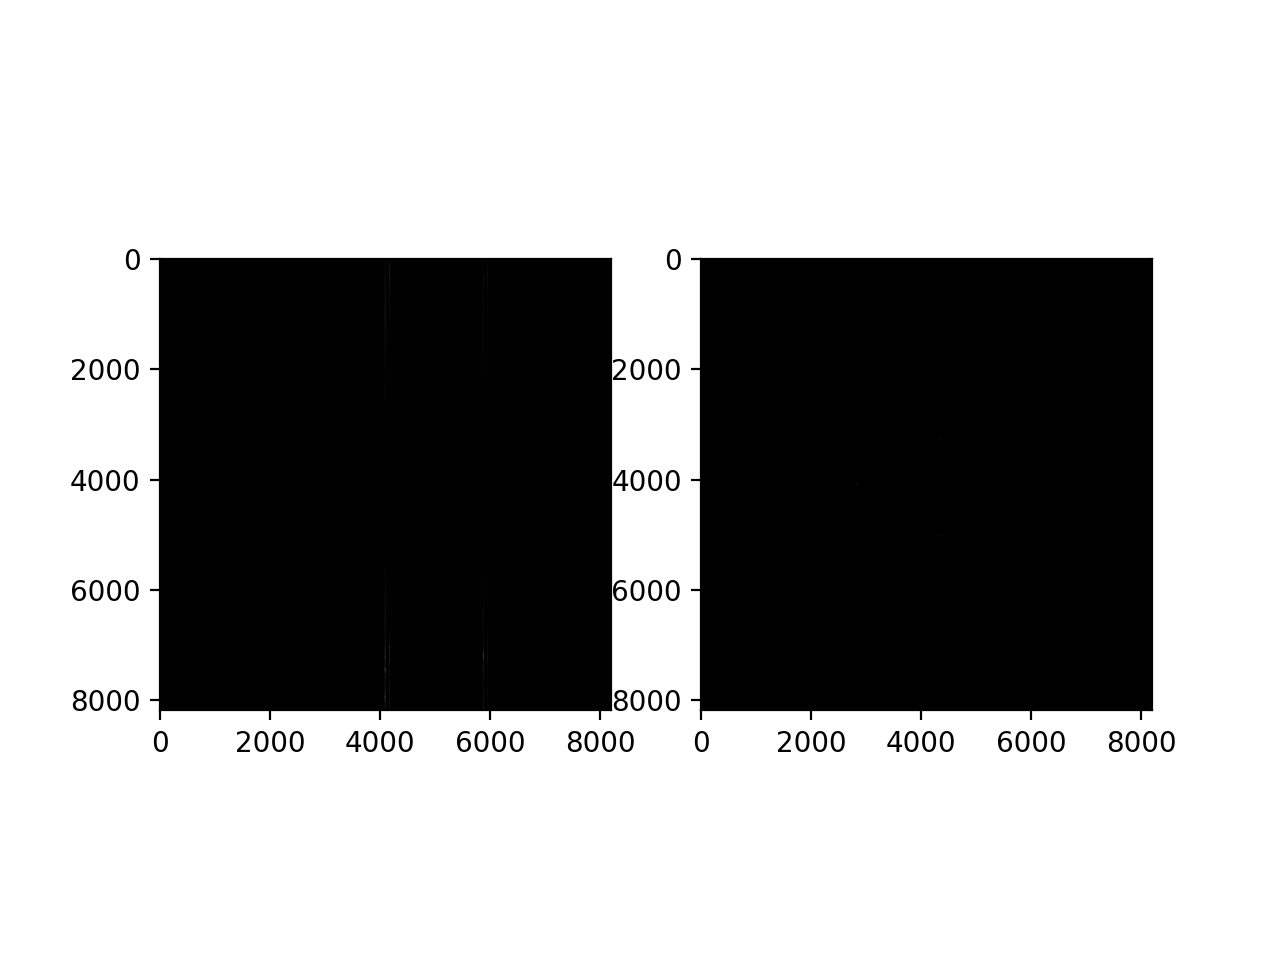

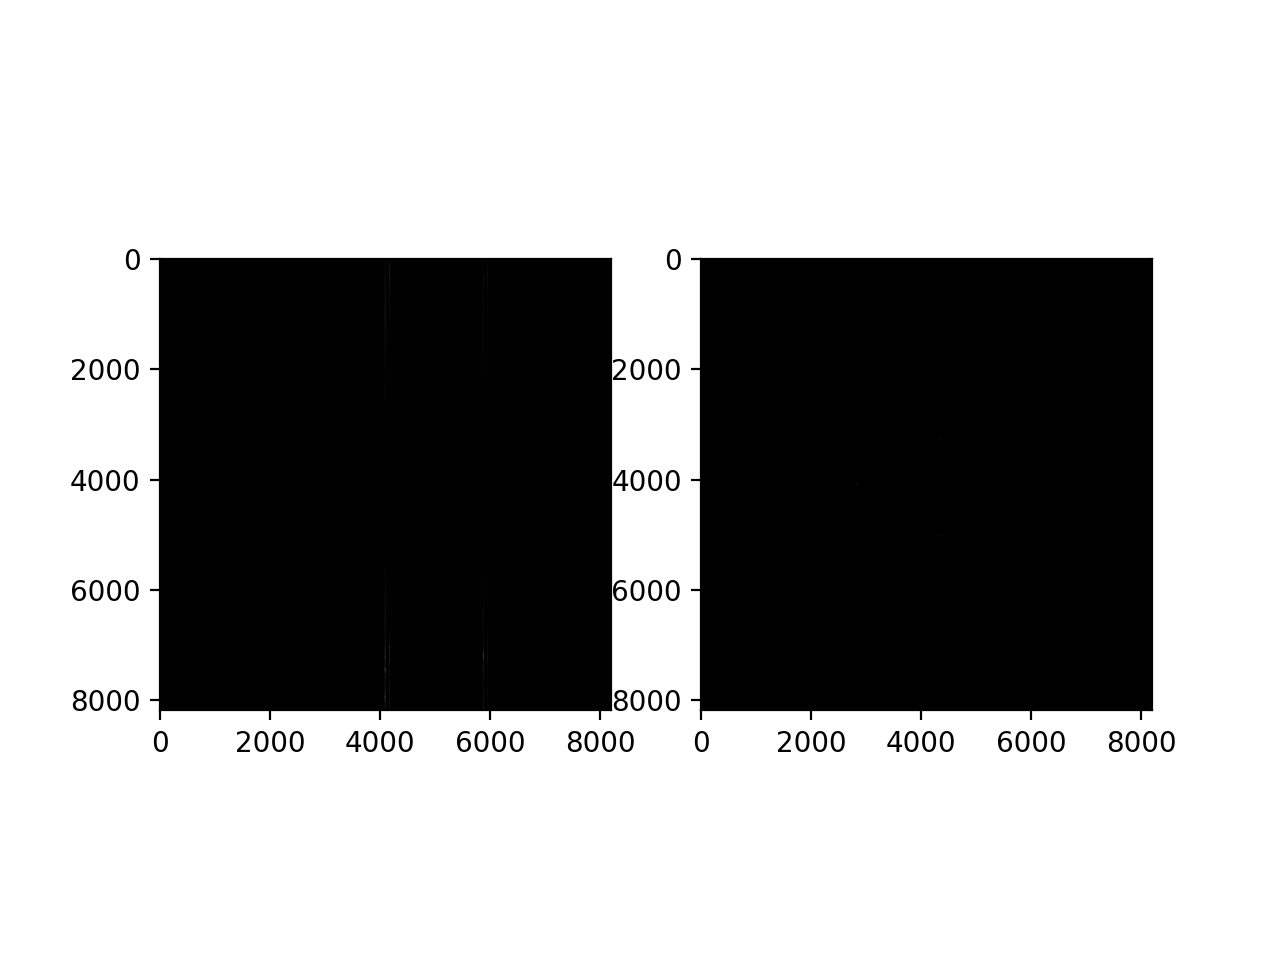

In [ ]:
fig, ax = plt.subplots(1,2)

#forward_test = load_psf(r"./Steve_3/steve_psf.pt", True)
#backward_test = torch.flip(forward_test,(1,2))
ax[0].imshow(result.cpu().detach().numpy(), cmap = 'gray')
#ax[0].imshow(torch.load('./test_images/0.pt')[0,:,:].detach().squeeze(0).squeeze(0).numpy(),'gray')
ax[1].imshow(backward_test[0,:,:].detach().numpy(),cmap='gray')
fig.show()

## Best of both worlds...?

Supposedly better performance by combining NRA and RLA together. Maybe also filter the back projector to make it even faster.

In [2]:
def rl_deconv(frames, PSF, PSF_bp, device, iterations = 10, path = r"./", cpu_option = 'cpu', temp_storage = False):
    # Take the whole lenslet image & the whole PSFs and apply the Richardson-Lucy algorithm to it
    # Frames should be in the format of [time, x, y]
    # PSF should be in the format of [depths, x, y]
    # Output should be in the format of [time, depth, x, y]
    # cpu_option is the device that does the division and the multiplication.
    # temp_storage dictates how the temporary storage is handled. If it is set to True, then the temporary storage is saved to the disk. If it is set to False, then the temporary storage is saved to the RAM.
    
    # So, FFTConv2D CAN work, it's just that we have to process one channel at a time and empty out cache after each iteration.
    # The problem is that the memory is not being freed up after each iteration. This is a problem with the way that the memory is being handled.
    
    conv2d = torch.nn.Conv2d(1, 1, kernel_size = (len(PSF_bp[0,:,0]), len(PSF_bp[0,0,:])), stride = 1, padding = 'same', bias = False).to(device)
    
    with torch.no_grad():
        if type(frames) != torch.Tensor:
            frames = torch.tensor(frames)
            gc.collect()
        
        if frames.dtype != torch.float16:
            frames = frames.to(torch.float16)
            gc.collect()
            
        if device == 'cuda':
            torch.cuda.empty_cache()
        
        for k in range(len(frames[:,0,0])):
            # Each time step
            print("Creating projected volume and image for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
            
            original_image = frames[k,:,:].clone().detach().to(cpu_option) # Format: (x,y)
            projected_volume = torch.empty([len(PSF[:,0,0]), len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float16).detach().to(cpu_option) # Format: (depth, x,y)
            projected_image = original_image.clone().detach() # Format: (x,y), we do not want the original image to be modified
            
            gc.collect()
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            for i in range(len(PSF[:,0,0])): # Save the projected volume to the CPU memory, but use gpu to do the calculations (if possible)
                conv2d.weights = torch.nn.parameter.Parameter(torch.div(PSF_bp[i,:,:].detach(), torch.sum(PSF_bp[i,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0))
                temp_vol = conv2d(original_image.detach().unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0)
                
                if temp_storage == True:
                    torch.save(temp_vol, path +'tempvol'+ '_' + str(i) + '.pt')
                    
                if temp_storage == False:
                    projected_volume[i,:,:] = temp_vol.to(cpu_option)
                    
                del temp_vol
                gc.collect()

                if device == 'cuda':
                    torch.cuda.empty_cache()
            
            for j in range(iterations):
                print("Now processing iteration " + str(j+1) + " out of " + str(iterations) + " for frame " + str(k+1) + " out of " + str(len(frames[:,0,0])))
                # Schema:
                # Calculate the projected image (Sum of o_i * PSF)
                # Divide the original image by the projected image (original_image / projected_image), (should be done on the cpu?)                
                # Convolve the ratio with the backward projector (ratio * PSF_bp)
                # Multiply the original image by the result of the convolution (original_image * result)
                # Repeat until the iterations are done
                
                # Denominator results in a projected image
                
                for i in range(len(PSF[:,0,0])):
                    conv2d.weight = torch.nn.parameter.Parameter(torch.div(PSF[i,:,:].detach(), PSF[i,:,:].detach()).detach().to(device).unsqueeze(0).unsqueeze(0))
                    
                    if temp_storage == True:
                        temp_vol = torch.load(path + 'tempvol' + '_' + str(i) + '.pt').to(device)
                        projected_image += conv2d(temp_vol.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option)
                        del temp_vol
                        gc.collect()
                    
                    projected_image += conv2d(projected_volume[i,:,:].unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0).to(cpu_option)
                    if temp_storage == False:
                        projected_image += conv2d(projected_volume[i,:,:].unsqueeze(0).unsqueeze(0).to(device)).squeeze(0).squeeze(0).to(cpu_option)
                    
                    if device == 'cuda':
                        torch.cuda.empty_cache()
                
                # We have the projected image, now take the ratio. The projected image is in 'device'.
                
                image_ratio = torch.nan_to_num(torch.div(original_image,projected_image).to(cpu_option), 1) # If the projected image is 0, then the ratio is 1
                
                # Convolve the ratio with the backward projector
                
                factor = torch.empty([len(PSF[:,0,0]),len(PSF[0,:,0]), len(PSF[0,0,:])], dtype = torch.float16).to(cpu_option) # Format: (depth,x,y)\
                
                for i in range(len(PSF_bp[:,0,0])):
                    conv2d.weight = torch.nn.parameter.Parameter(torch.div(PSF_bp[i,:,:].detach(), torch.sum(PSF_bp[i,:,:].detach())).detach().to(device).unsqueeze(0).unsqueeze(0).to(device))
                    factor = conv2d(image_ratio.to(device).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option)
                    
                    if temp_storage == True:
                        torch.save(factor, path + 'factor' + '_' + str(i) + '.pt')
                        
                    elif temp_storage == False:
                        factor[i,:,:] = conv2d(image_ratio.to(device).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0).to(cpu_option)
                    
                del image_ratio # We don't need this anymore
                gc.collect()
                
                if device == 'cuda':
                    torch.cuda.empty_cache()
                
                # We have the new factor, now multiply it by the original volume
                if temp_storage == True:
                    for i in range(len(PSF[:,0,0])):
                        temp_vol = torch.load(path + 'tempvol' + '_' + str(i) + '.pt').to(cpu_option)
                        temp_factor = torch.load(path + 'factor' + '_' + str(i) + '.pt').to(cpu_option)
                        torch.save(torch.mul(temp_vol, temp_factor), path +'tempvol'+ '_' + str(i) + '.pt')
                        
                        del temp_vol, temp_factor
                        gc.collect()
                        
                        if device == 'cuda':
                            torch.cuda.empty_cache()
                
                if temp_storage == False:    
                    projected_volume[:,:,:] = torch.mul(projected_volume[:,:,:].to(cpu_option), factor[:,:,:].to(cpu_option)).to(cpu_option)
            
            print("Finished processing frame " + str(k+1) + " out of " + str(len(frames[:,0,0])) + ", now saving the results")
            if temp_storage == False:
                torch.save(projected_volume, path + str(k) + '.pt')
                  
            for i in range(len(PSF[:,0,0])):
                if temp_storage == True:
                    os.rename(path + 'tempvol' + '_' + str(i) + '.pt', path + str(k) + '_' + str(i) + '.pt')
        
        del projected_volume, projected_image, original_image, factor
        gc.collect()
        
        if device == 'cuda':
            torch.cuda.empty_cache()
            
    return None

# Add the lenslets together and reconstruct to 3D

In [ ]:
steve_depths = np.linspace(-20000, 20000, 11) # Depths in microns, with 11 total depths

In [ ]:
reconstructions = combine_lenslets(circles_corrected, steve_depths, r"./test_images/")

UnboundLocalError: cannot access local variable 'x_start' where it is not associated with a value